# I] Import and download

In [1]:
import pandas, numpy
import scipy, scipy.signal
import matplotlib, matplotlib.pyplot as plt

In [2]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

In [3]:
path = output_file_directory + "dataframes_for_input/"

In [4]:
%%time
# DL data gene expression for Normal Tissue and Primary Tumors
df_normal = pandas.read_csv(path+"ensembl_normal_protcoding_expr.tsv", sep = "\t")
df_primary = pandas.read_csv(path+"ensembl_primary_protcoding_expr.tsv", sep = "\t")

print(df_normal.shape)
print(df_primary.shape)

df_normal.head(2)

(7429, 19383)
(9185, 19383)
Wall time: 3min 32s


,sample,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,ENSG00000198899,ENSG00000198938,ENSG00000198840,ENSG00000212907,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
0,GTEX-1117F-0226-SM-5GZZ7,13.1350,12.6215,12.6246,12.8384,13.9763,13.1286,13.5276,11.9137,12.0779,...,4.2840,5.3992,5.3851,4.6247,4.8258,5.4912,3.1294,5.6224,4.5663,6.4249
1,GTEX-1117F-0426-SM-5EGHI,14.6712,14.2931,14.5995,14.7048,15.7851,15.3795,15.3725,13.0616,13.6227,...,7.7997,4.4357,4.5802,1.5563,4.8365,6.3473,2.4597,6.6948,0.8568,2.8055


# II] Data transformation

In [5]:
%%time
# transform Normal data to tpm + 1
df_normal.set_index('sample', inplace = True)  
df_primary.set_index('sample', inplace = True)  

# transform Normal data to tpm + 1   
print(f'NORMAL \nmin inlog2(tpm+0.001) : {df_normal.min().min()}')
df_normal = ((2**df_normal) - 0.001) + 1
print(f'min in tpm+1 : {df_normal.min().min()}')
df_normal = numpy.log2(df_normal) 
print(f'min in log2(tpm+1) : {df_normal.min().min()}')

# transform Primary data to tpm + 1   
print(f'\nPRIMARY \nmin inlog2(tpm+0.001) : {df_primary.min().min()}')
df_primary = ((2**df_primary) - 0.001) + 1
print(f'min in tpm+1 : {df_primary.min().min()}')
df_primary = numpy.log2(df_primary) 
print(f'min in log2(tpm+1) : {df_primary.min().min()}')

df_normal.head(2)

NORMAL 
min inlog2(tpm+0.001) : -9.9658
min in tpm+1 : 0.9999999891070172
min in log2(tpm+1) : -1.5715252422426845e-08

PRIMARY 
min inlog2(tpm+0.001) : -9.9658
min in tpm+1 : 0.9999999891070172
min in log2(tpm+1) : -1.5715252422426845e-08
Wall time: 7.87 s


,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,ENSG00000198899,ENSG00000198938,ENSG00000198840,ENSG00000212907,ENSG00000198886,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
sample,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,13.135160,12.621729,12.624828,12.838597,13.976389,13.128761,13.527722,11.914074,12.078233,12.530644,...,4.356148,5.432954,5.419182,4.681969,4.875745,5.522892,3.285359,5.651364,4.625886,6.441578
GTEX-1117F-0426-SM-5EGHI,14.671255,14.293172,14.599558,14.704854,15.785126,15.379534,15.372534,13.061769,13.622814,14.297172,...,7.806154,4.500807,4.639227,1.978191,4.886082,6.364894,2.700445,6.708646,1.490579,2.998197


In [6]:
#remove gene where the maximum is lower than 10 TPM 
dfs =  df_normal, df_primary
infos = 'normal', 'primary'

df_L = []
for i in range(len(dfs)):
    df = dfs[i]
    info = infos[i]
    
    print(f'\n {info.upper()} \nshape is: {df.shape}')
    #remove gene where the maximum is lower than 10 TPM 
    max_number_log2_tpm_p1 = 3.322
    df = df.loc[:, (df.max() > max_number_log2_tpm_p1)]
    print(f'minimum of the max expression is {df.max().min()} [log2(tpm+1)]')
    print(f'new shape is: {df.shape}')
    df_L.append(df)

df_normal = df_L[0].T
df_primary = df_L[1].T


 NORMAL 
shape is: (7429, 19382)
minimum of the max expression is 3.3233815747991775 [log2(tpm+1)]
new shape is: (7429, 17993)

 PRIMARY 
shape is: (9185, 19382)
minimum of the max expression is 3.3233815747991775 [log2(tpm+1)]
new shape is: (9185, 18248)


In [7]:
df_normal.head()

sample,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2226-SM-5N9CH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-3026-SM-5GZYU,...,GTEX-ZZPU-0726-SM-5N9C8,GTEX-ZZPU-0926-SM-5GZYT,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
ENSG00000198888,13.135160,14.671255,12.892590,12.626528,13.833999,13.796301,10.462722,11.971959,14.579059,13.647612,...,12.856694,14.807350,14.324070,14.077683,14.160279,13.710608,12.875992,12.543841,14.608858,14.322870
ENSG00000198763,12.621729,14.293172,12.661422,13.083466,14.178278,13.815800,11.522490,12.455857,14.316871,12.911187,...,13.035472,14.654956,14.349269,14.271173,14.381068,14.243274,13.394134,12.824699,14.249174,14.383067
ENSG00000198804,12.624828,14.599558,12.501049,11.333958,15.359034,12.269492,10.351304,11.283978,13.617715,14.068484,...,13.396634,15.990122,15.275036,15.172639,14.855149,14.608458,13.524222,14.093182,15.529030,14.397067
ENSG00000198712,12.838597,14.704854,12.845796,12.693018,14.849549,13.460228,11.164428,12.173512,13.765803,13.974990,...,13.360737,15.377334,14.987344,14.652856,14.776051,14.834049,13.438830,14.168778,15.161439,14.372868
ENSG00000228253,13.976389,15.785126,13.925293,14.103782,16.324118,15.393233,12.921886,13.742005,15.662428,14.605158,...,14.311871,16.423816,15.525131,15.884424,15.810425,15.494831,14.917247,14.816350,16.016622,15.288736


# III] Distribution of filtering

In [8]:
# find max
print(df_normal.max().max())
print(df_primary.max().max())

18.985002777698735
17.89430591586269


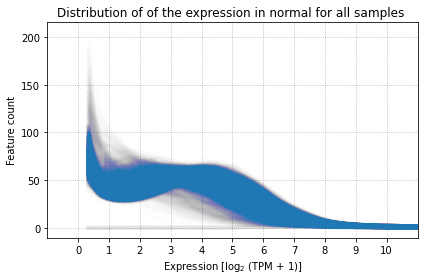

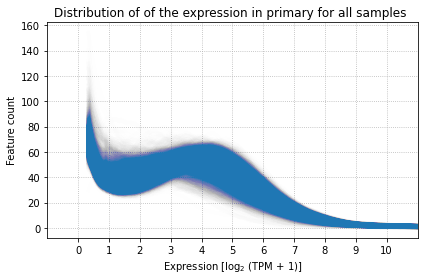

Wall time: 53.8 s


In [9]:
%%time
#show everything. All the samples 
found_max = 19
#means 50 dots per bins
resolution = 50
number_of_bins = found_max * resolution
absolute_max = 0
#remove at extremities
margin = int(resolution/3)

dfs = df_normal, df_primary
infos = "normal", "primary"

for i in range(len(dfs)):
    df = dfs[i]
    info = infos[i]  

    for sample in df.columns:
        expression_values = df.loc[:, sample]

        # histogram
        hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
        half_bin = (bin_edges[1] - bin_edges[0])/2
        x = bin_edges + half_bin
        x = x[:-1]

        # curve fitting - smooth
        plotting_x = x[margin:-margin]
        plotting_hist = hist[margin:-margin]
        yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
        
        # plotting
        plt.plot(plotting_x, yhat, '-', lw=4, alpha=1/300, color='tab:blue')

    plt.xlim(-1, 11)                  
    plt.xticks(range(0, 10+1))
    plt.title(f'Distribution of of the expression in {info} for all samples ')
    plt.xlabel('Expression [log$_2$ (TPM + 1)]')
    plt.ylabel('Feature count')
    plt.grid(ls=':')
    plt.tight_layout()
    plt.show()
    plt.close()

7429


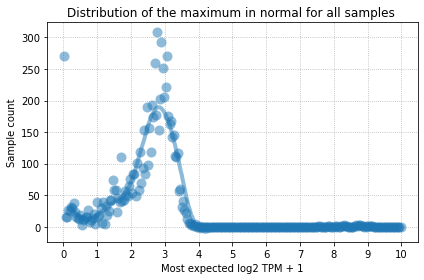

9185


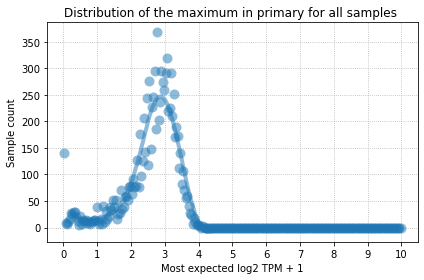

Wall time: 23.2 s


In [10]:
%%time
#Plot the maximum of expression to find a communal pattern among samples
#because we saw bad sample in the beginning until 1. I remove the 50 values first with margin

found_max = 19
# means 50 dots per bins (betweeen 0 and 1)
resolution = 50
number_of_bins = found_max * resolution
absolute_max = 0

dfs = df_normal, df_primary
infos = "normal", "primary"

for i in range(len(dfs)):
    df = dfs[i]
    info = infos[i]  
    
    most_likely_expressions = []
    for sample in df.columns:
        expression_values = df.loc[:, sample]

        # histogram of all sample (without the beginning of the values = no pic at 0)
        hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
        half_bin = (bin_edges[1] - bin_edges[0])/2
        x = bin_edges + half_bin
        x = x[:-1]
        
        # curve fitting
        margin = 50
        plotting_x = x[margin:-margin]
        plotting_hist = hist[margin:-margin]
        yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
        
        # To visualize the communal pattern in samples : maximum of all samples 
        ## argmax gives position of the max.
        most_likely_expression = x[numpy.argmax(yhat)]
        most_likely_expressions.append(most_likely_expression)
        
    # histogram of the maximum value of all samples
    print(len(most_likely_expressions))
    hist, bin_edges = numpy.histogram(most_likely_expressions, bins=250, range=(0, 10))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]

    # curve fitting
    margin = 5
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)

    #plot
    plt.plot(x, hist, 'o', color='tab:blue', alpha=1/2, markeredgecolor='None', markersize=10)
    plt.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color='tab:blue')

    plt.xticks(range(0, 11))
    plt.grid(ls=':')
    plt.title(f'Distribution of the maximum in {info} for all samples ')
    plt.xlabel('Most expected log2 TPM + 1')
    plt.ylabel('Sample count')
    plt.tight_layout()
    plt.show()
    plt.close()

In [11]:
print('The communal pattern of the maximal is mainly between 1.8 and 3.8 in the two groups')

The communal pattern of the maximal is mainly between 1.8 and 3.8 in the two groups


In [12]:
%%time
# We want to select only the samples following the pattern.

found_max = 19
#means 50 dots per bins
resolution = 50
number_of_bins = found_max * resolution
absolute_max = 0
margin = 50

dfs = df_normal, df_primary
infos = "normal", "primary"

selected_expressions = []

for i in range(len(dfs)):
    df = dfs[i]
    info = infos[i]
    
    print(info)
    selected_samples = []
    
    for sample in df.columns:
        expression_values = df.loc[:, sample]

        # histogram
        hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
        half_bin = (bin_edges[1] - bin_edges[0])/2
        x = bin_edges + half_bin
        x = x[:-1]

        # curve fitting - smooth
        plotting_x = x[margin:-margin]
        plotting_hist = hist[margin:-margin]
        yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
        
        # determine most likely expression
        ## argmax gives position of the max. This is to select samples with max at this range
        most_likely_expression = x[numpy.argmax(yhat)]

        # sample selection. Where max is between 1.8 and 3.8.
        if 1.8 <= most_likely_expression <= 3.8:
            selected_samples.append(sample)
            
    selected_expression = df.loc[:, selected_samples]
    print(selected_expression.shape)
    selected_expressions.append(selected_expression)

# create the new dataframe
selected_expr_normal = selected_expressions[0]
selected_expr_primary = selected_expressions[1]
selected_expr_normal.head(3)

normal
(17993, 5914)
primary
(18248, 8022)
Wall time: 23.3 s


sample,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2226-SM-5N9CH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-3026-SM-5GZYU,...,GTEX-ZZPU-0326-SM-5N9BJ,GTEX-ZZPU-0526-SM-5E44U,GTEX-ZZPU-0726-SM-5N9C8,GTEX-ZZPU-0926-SM-5GZYT,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2726-SM-5NQ8O
ENSG00000198888,13.135160,14.671255,12.892590,12.626528,13.833999,13.796301,10.462722,11.971959,14.579059,13.647612,...,13.630914,13.258647,12.856694,14.807350,14.324070,14.077683,13.710608,12.875992,12.543841,14.322870
ENSG00000198763,12.621729,14.293172,12.661422,13.083466,14.178278,13.815800,11.522490,12.455857,14.316871,12.911187,...,13.608215,13.410832,13.035472,14.654956,14.349269,14.271173,14.243274,13.394134,12.824699,14.383067
ENSG00000198804,12.624828,14.599558,12.501049,11.333958,15.359034,12.269492,10.351304,11.283978,13.617715,14.068484,...,13.964490,13.839598,13.396634,15.990122,15.275036,15.172639,14.608458,13.524222,14.093182,14.397067


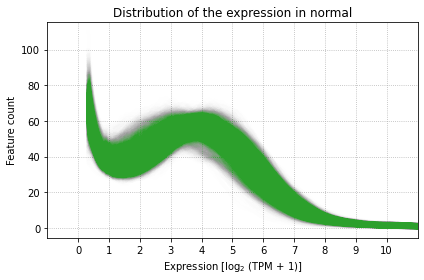

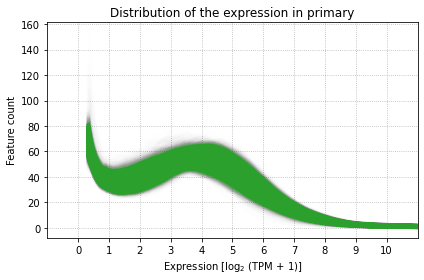

Wall time: 43.7 s


In [13]:
%%time
#Plot the distribution of the selected samples
found_max = 19
#means 50 dots per bins
resolution = 50
number_of_bins = found_max * resolution
absolute_max = 0
#remove at extremities
margin = int(resolution/3)

dfs = selected_expr_normal, selected_expr_primary
infos = "normal", "primary"

most_likely_expressions = []
selected_samples = []

for i in range(len(dfs)):
    df = dfs[i]
    info = infos[i]  

    for sample in df.columns:
        expression_values = df.loc[:, sample]

        # histogram
        hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
        half_bin = (bin_edges[1] - bin_edges[0])/2
        x = bin_edges + half_bin
        x = x[:-1]

        # curve fitting - smooth
        plotting_x = x[margin:-margin]
        plotting_hist = hist[margin:-margin]
        yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
               
        # plotting
        plt.plot(plotting_x, yhat, '-', lw=4, alpha=1/300, color='tab:green')

    plt.xlim(-1, 11)                  
    plt.xticks(range(0, 10+1))
    plt.title(f'Distribution of the expression in {info}')
    plt.xlabel('Expression [log$_2$ (TPM + 1)]')
    plt.ylabel('Feature count')
    plt.grid(ls=':')
    plt.tight_layout()
    plt.show()
    plt.close()

In [14]:
selected_expr_normal = selected_expr_normal.T
selected_expr_primary = selected_expr_primary.T

print(selected_expr_normal.shape)
print(selected_expr_primary.shape)

(5914, 17993)
(8022, 18248)


In [15]:
%%time
#save to csv
selected_expr_normal.to_csv(path+'filtered_samples_protcod_expr_normal.tsv',sep = "\t")
selected_expr_primary.to_csv(path+'filtered_samples_protcod_expr_protein.tsv',sep = "\t")

Wall time: 8min 20s
